##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

--2020-05-12 15:13:42--  https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  7.22MB/s    in 1.7s    

2020-05-12 15:13:44 (7.22 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


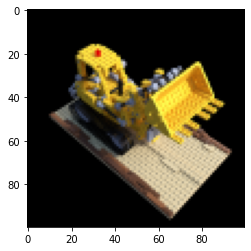

In [3]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [4]:

L_embed = 6
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)


embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)
    sigma_map = tf.reduce_sum(weights * sigma_a, -1) 
    
    # print(pts_flat.shape, pts.shape, sigma_a.shape, rays_o.shape, rays_d.shape, z_vals.shape)

    return rgb_map, depth_map, acc_map, sigma_map


def query_network_xyz(network_fn, points:np.ndarray):
    def batchify(fn, chunk=1024*32):
      return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)    
    # Run network
    pts_flat = tf.reshape(points, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(points.shape[:-1]) + [4])
    
    # Compute opacities and colors
    return tf.nn.relu(raw[...,3])

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.03908708572387695 secs per iter


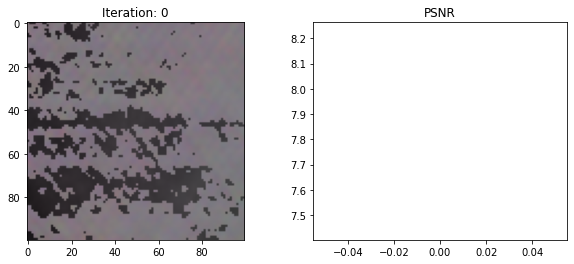

25 0.3820172119140625 secs per iter


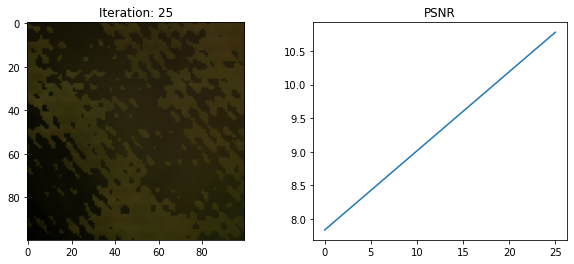

50 0.3830173683166504 secs per iter


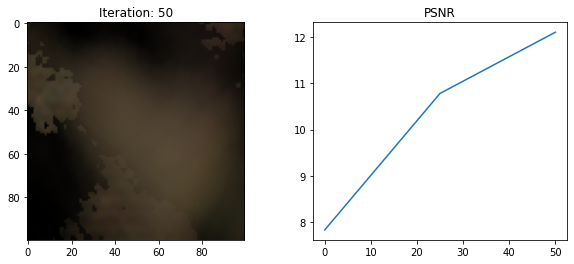

75 0.3806980800628662 secs per iter


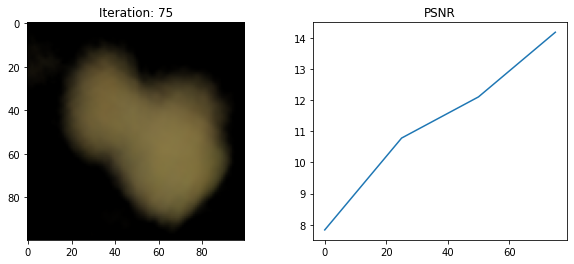

100 0.3785451507568359 secs per iter


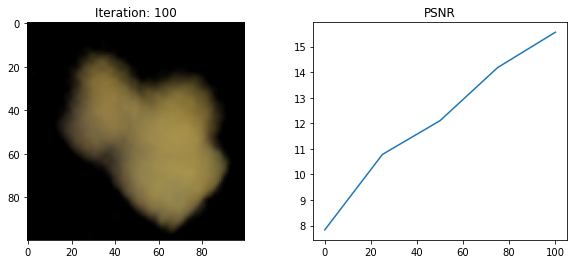

125 0.37851873397827146 secs per iter


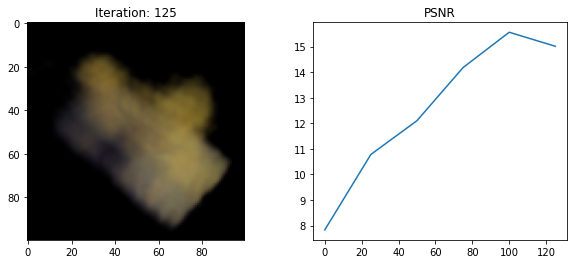

150 0.37993057250976564 secs per iter


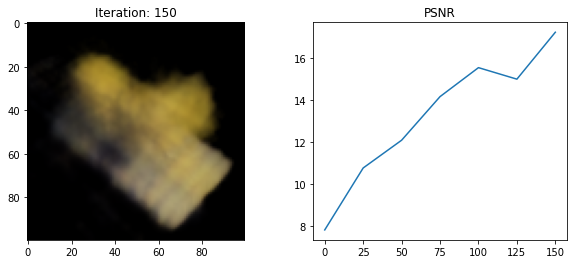

175 0.38218838691711426 secs per iter


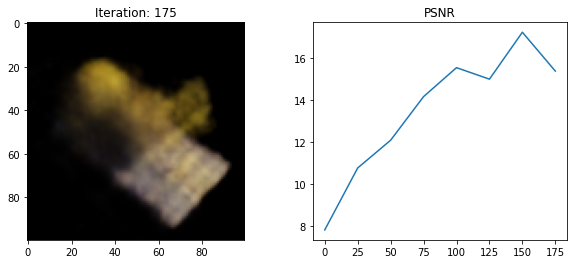

200 0.3798634338378906 secs per iter


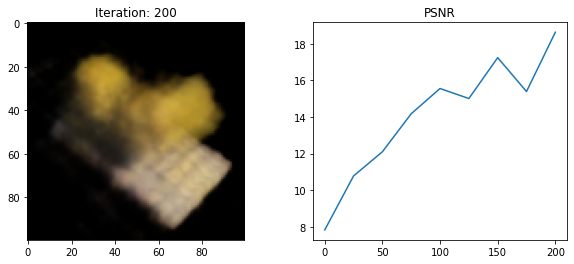

225 0.3797597312927246 secs per iter


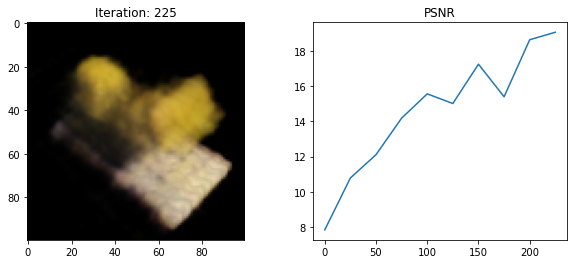

250 0.383212890625 secs per iter


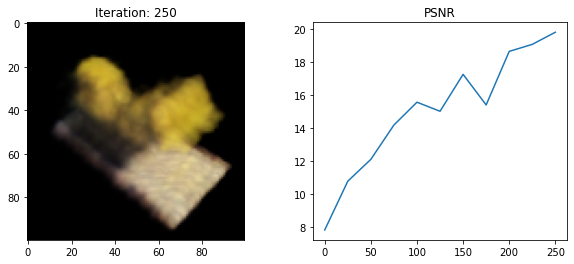

275 0.38092262268066407 secs per iter


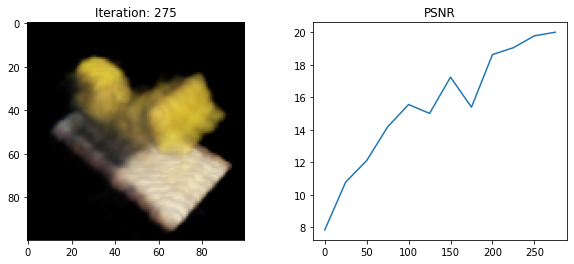

300 0.3824729347229004 secs per iter


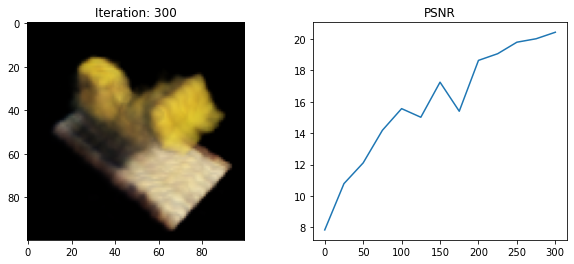

325 0.38101513862609865 secs per iter


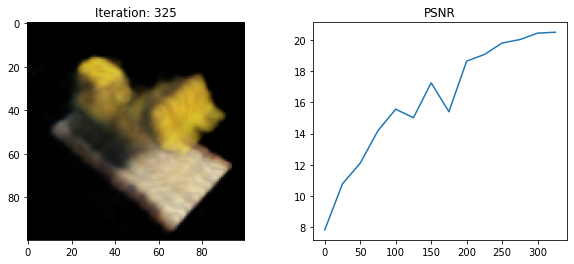

350 0.383285551071167 secs per iter


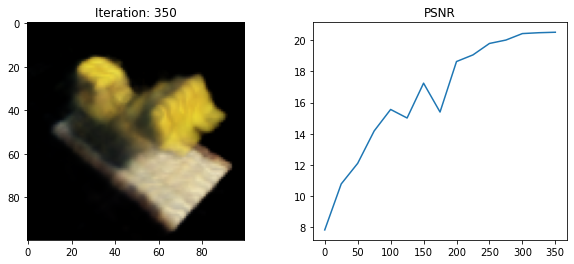

375 0.38057540893554687 secs per iter


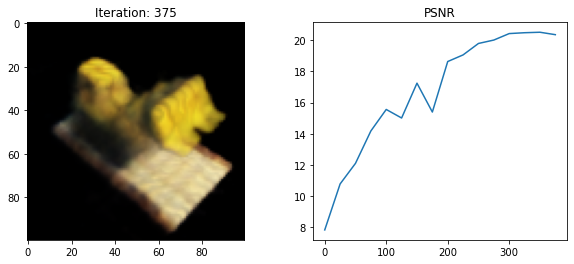

400 0.3812274932861328 secs per iter


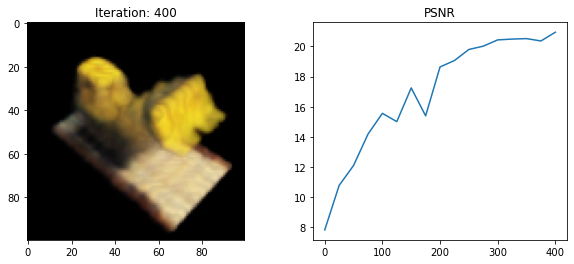

425 0.38341217041015624 secs per iter


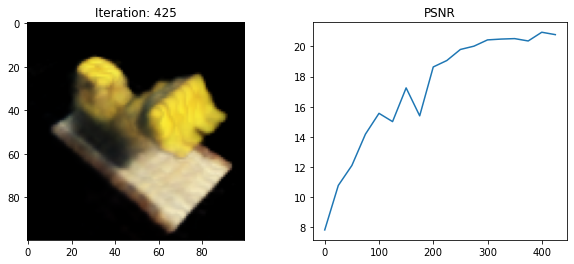

450 0.381504602432251 secs per iter


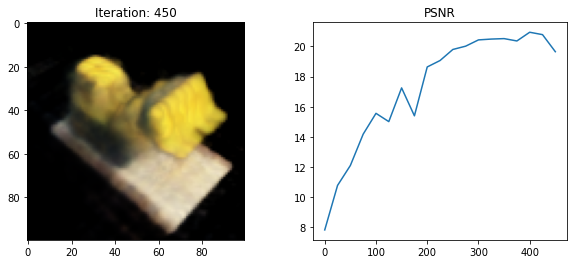

475 0.3820217323303223 secs per iter


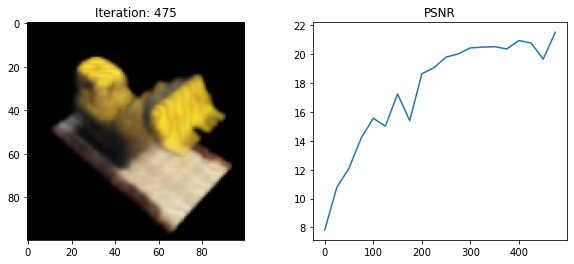

500 0.38174403190612793 secs per iter


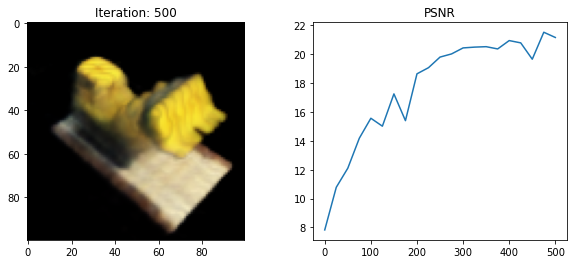

525 0.3826449489593506 secs per iter


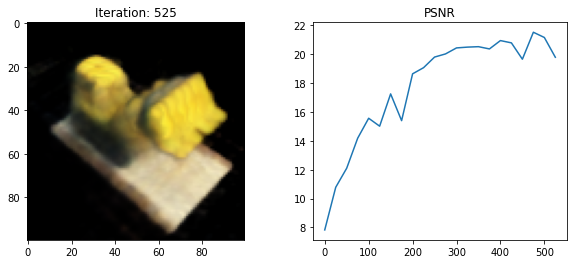

550 0.3816161441802979 secs per iter


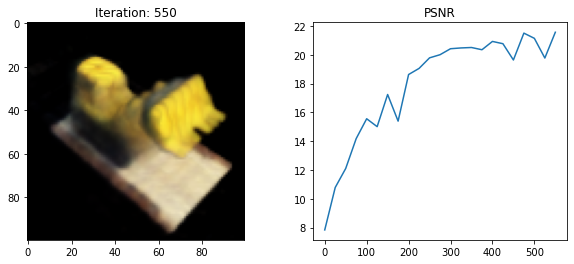

575 0.3803990650177002 secs per iter


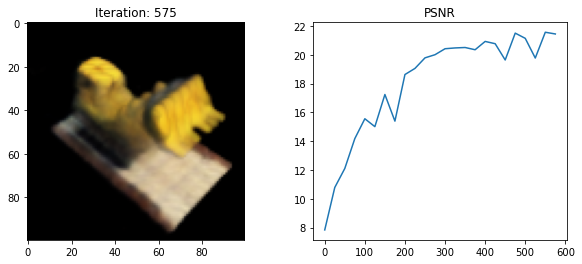

600 0.3834319496154785 secs per iter


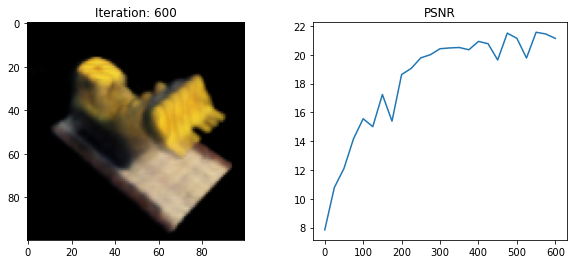

625 0.38209150314331053 secs per iter


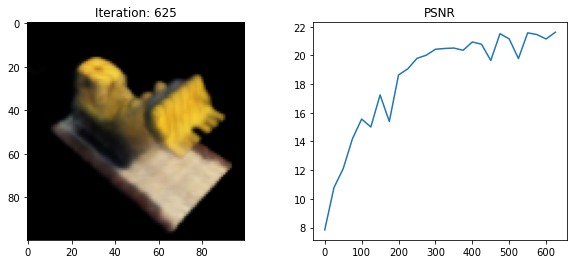

650 0.38244674682617186 secs per iter


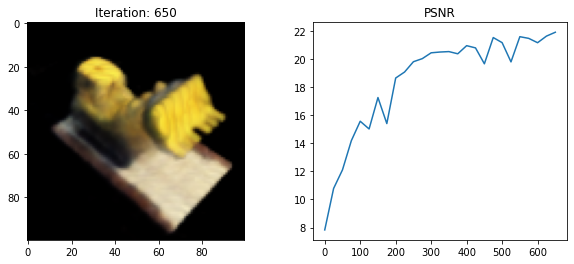

675 0.3822438144683838 secs per iter


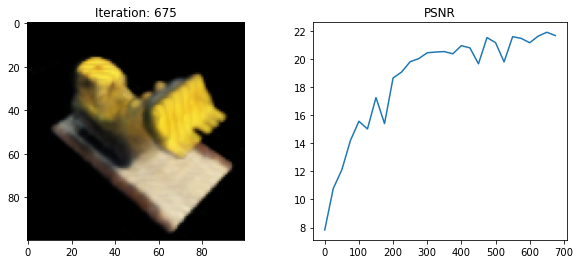

700 0.384021635055542 secs per iter


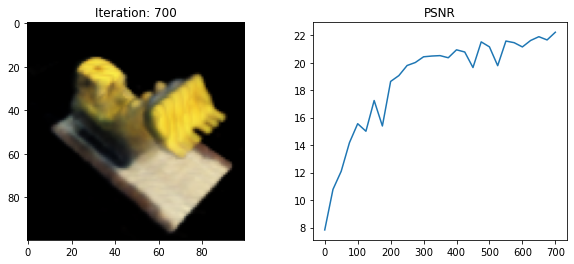

725 0.38151341438293457 secs per iter


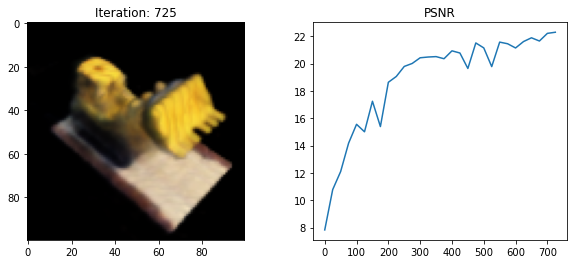

750 0.38298086166381834 secs per iter


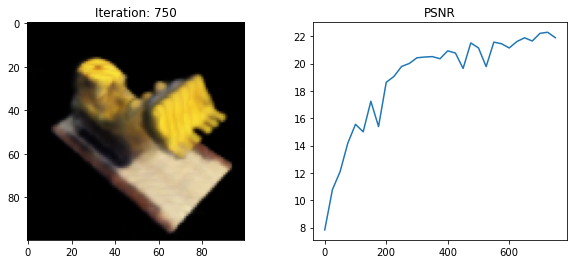

775 0.38400989532470703 secs per iter


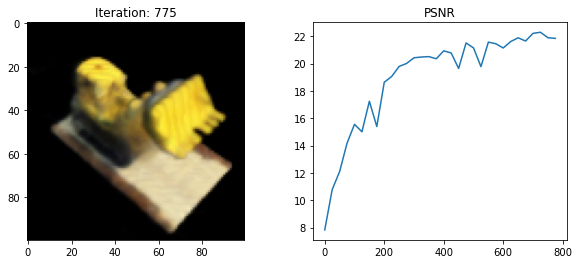

800 0.3824179649353027 secs per iter


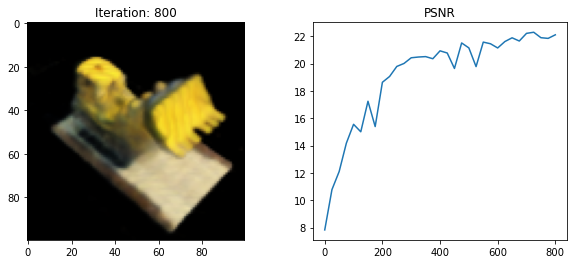

825 0.3809437847137451 secs per iter


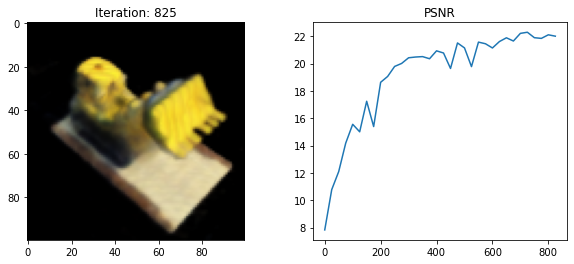

850 0.38203457832336424 secs per iter


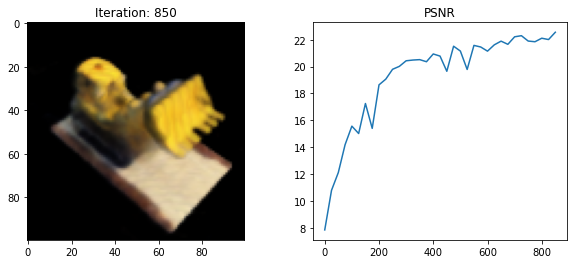

875 0.38487895011901857 secs per iter


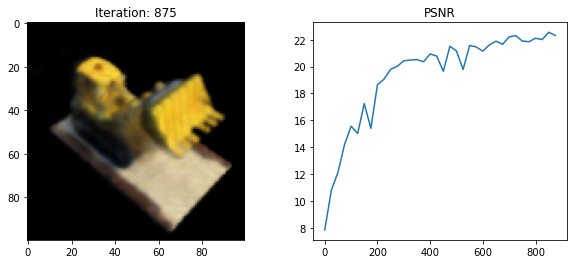

900 0.3838776874542236 secs per iter


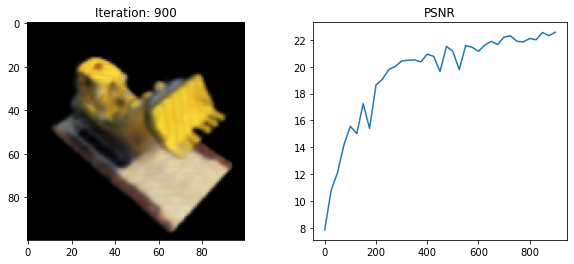

925 0.3820769786834717 secs per iter


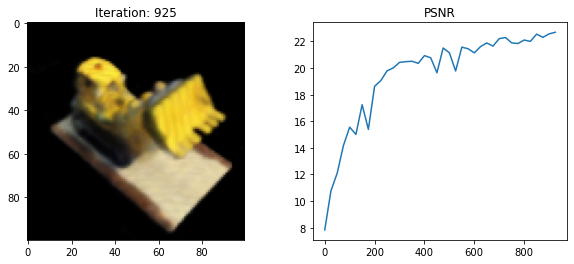

950 0.38636547088623047 secs per iter


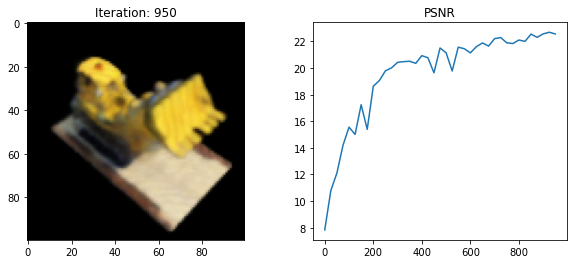

975 0.3846113586425781 secs per iter


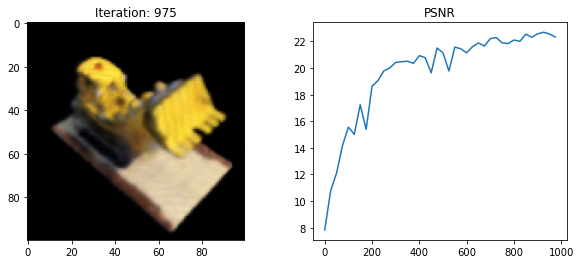

1000 0.38360474586486815 secs per iter


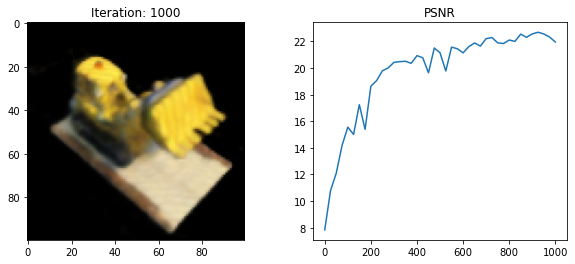

Done


In [5]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc, _ = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc, _ = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [96]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    print(f'**kwargs:{kwargs}')
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc, sigma = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
#     img = depth
    # img = sigma
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [95]:
# input_point = np.array([0.,0.,0.], dtype=np.float)
# input_point = tf.convert_to_tensor([
#                                     [1,0,0],
#                                     [0,1,0],
#                                     [0,0,1],
#                                     ], dtype=tf.float32)

# query_network_xyz(model, input_point)
grid_points = 100
def plotting_function(**kwargs):
    from itertools import product

    xx = np.linspace(-1., 1., num=grid_points, endpoint=True, dtype=np.float)
    x_fix = np.array([kwargs['x_fix']])
    y_fix = np.array([kwargs['y_fix']])
    z_fix = np.array([kwargs['z_fix']])
    
    x_fix_points = np.array( list(product(x_fix, xx, xx)))
    y_fix_points = np.array( list(product(xx, y_fix, xx)))
    z_fix_points = np.array( list(product(xx, xx, z_fix)))
    
    x_fix_sigma = np.reshape(query_network_xyz(model, tf.convert_to_tensor(x_fix_points, dtype=tf.float32)).numpy(), newshape=(grid_points, grid_points))
    y_fix_sigma = np.reshape(query_network_xyz(model, tf.convert_to_tensor(y_fix_points, dtype=tf.float32)).numpy(), newshape=(grid_points, grid_points))
    z_fix_sigma = np.reshape(query_network_xyz(model, tf.convert_to_tensor(z_fix_points, dtype=tf.float32)).numpy(), newshape=(grid_points, grid_points))
    
    xx_mesh, xx_mesh2 = np.meshgrid(xx, xx)

    f = plt.figure(figsize=(15,4))
    ax_xy = f.add_subplot(131)
    ax_yz = f.add_subplot(132)
    ax_zy = f.add_subplot(133)

    im = ax_xy.contourf(xx_mesh2, xx_mesh, x_fix_sigma)
    f.colorbar(im, ax=ax_xy)
    im = ax_yz.contourf(xx_mesh2, xx_mesh, y_fix_sigma)
    f.colorbar(im, ax=ax_yz)
    im = ax_zy.contourf(xx_mesh, xx_mesh2, z_fix_sigma)
    f.colorbar(im, ax=ax_zy)
    

def test_plot(**kwargs):

    xvec = np.linspace(-5.,5.,100)                               
    x,y = np.meshgrid(xvec, xvec)
    z = -np.hypot(x, y)                                
    print(x.shape, y.shape, z.shape)
    plt.contourf(x, y, z, 100)                             
    plt.colorbar() 

    plt.axhline(0, color='white')
    plt.axvline(0, color='white')

    plt.show()
    

xyz_sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

slice_names = [
    ['x_fix', [0., -1., 1.]],
    ['y_fix', [0., -1., 1.]],
    ['z_fix', [0., -1., 1.]],
]

interactive_plot_slices = interactive(plotting_function, **{s[0] : xyz_sldr(*s[1]) for s in slice_names})
output_slices = interactive_plot_slices.children[-1]
output_slices.layout.height = '500px'
interactive_plot_slices

interactive(children=(FloatSlider(value=0.0, description='x_fix', max=1.0, min=-1.0, step=0.01), FloatSlider(v…

# Render 360 Video

In [8]:
frames = []
phi = -30.
r = 4.
N = 120
theta_space = np.linspace(0., 360., 120, endpoint=False)
r_space = np.linspace(4., 0.5, 120, endpoint=False)
for th, r in tqdm(zip(theta_space, r_space), total=theta_space.shape[0]):
    c2w = pose_spherical(th, phi, r)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc, sigma = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    # RGB
    # frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))
    
    # Depth
    depth /= np.max(depth)
    frames.append((255*depth.numpy()).astype(np.uint8))
    
    # Sigma
    # sigma /= np.max(depth)
    # frames.append((255*sigma.numpy()).astype(np.uint8))
import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/home/adam/anaconda3/envs/nerf/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [9]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)